---
title: "Warp image using perspective transform"
description: "In this tutorial we are going to learn how to use the functions [kornia.get_perspective_transform](https://kornia.readthedocs.io/en/latest/geometry.transform.html#kornia.geometry.transform.get_perspective_transform) and [kornia.warp_perspective](https://kornia.readthedocs.io/en/latest/geometry.transform.html#kornia.geometry.transform.warp_perspective)."
author:
    - "Edgar Riba"
date: 03-18-2021
categories:
    - Intermediate
    - Warp image
    - kornia.geometry
image: "../tutorials/assets/warp_perspective.png"
---

<a href="https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/warp_perspective.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in google colab"></a>

## Install libraries and get the data

In [ ]:
%%capture
!pip install kornia
!pip install kornia-rs

In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url = "https://github.com/kornia/data/raw/main/bruce.png"
download_image(url)

'bruce.png'

## Import libraries and load the data

In [ ]:
import cv2
import kornia as K
import matplotlib.pyplot as plt
import torch

In [ ]:
img = K.io.load_image("bruce.png", K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
print(img.shape)

torch.Size([1, 3, 372, 600])


## Define the points to warp, compute the homography and warp

In [ ]:
# the source points are the region to crop corners
points_src = torch.tensor(
    [
        [
            [125.0, 150.0],
            [562.0, 40.0],
            [562.0, 282.0],
            [54.0, 328.0],
        ]
    ]
)

# the destination points are the image vertexes
h, w = 64, 128  # destination size
points_dst = torch.tensor(
    [
        [
            [0.0, 0.0],
            [w - 1.0, 0.0],
            [w - 1.0, h - 1.0],
            [0.0, h - 1.0],
        ]
    ]
)

# compute perspective transform
M: torch.tensor = K.geometry.get_perspective_transform(points_src, points_dst)

# warp the original image by the found transform
img_warp: torch.tensor = K.geometry.warp_perspective(img.float(), M, dsize=(h, w))
print(img_warp.shape)

torch.Size([1, 3, 64, 128])


## Plot the warped data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<matplotlib.image.AxesImage>

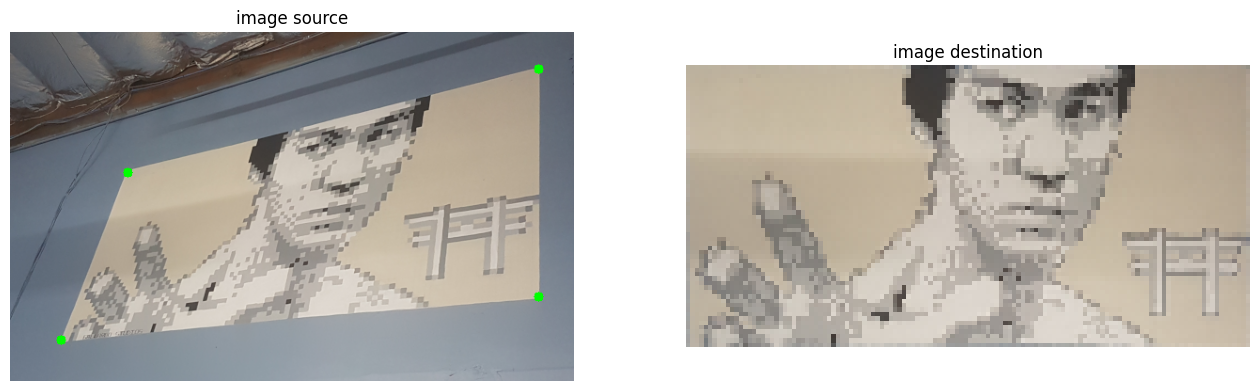

In [ ]:
# convert back to numpy
img_np = K.tensor_to_image(img)
img_warp_np = K.tensor_to_image(img_warp)

# draw points into original image
for i in range(4):
    center = tuple(points_src[0, i].long().numpy())
    img_np = cv2.circle(img_np.copy(), center, 5, (0, 255, 0), -1)

# create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis("off")
axs[0].set_title("image source")
axs[0].imshow(img_np)

axs[1].axis("off")
axs[1].set_title("image destination")
axs[1].imshow(img_warp_np)
plt.show()